# Practical task sheet 01 -- color space conversion, subsampling, chroma keying and noise

The first practical task sheet will be about color conversion and chrome keying.
For this please checkout the following links:

* https://en.wikipedia.org/wiki/Color_space
* https://en.wikipedia.org/wiki/YCbCr
* https://en.wikipedia.org/wiki/Chroma_subsampling
* https://en.wikipedia.org/wiki/Chroma_key
* https://en.wikipedia.org/wiki/Image_noise

Transmission standards use different color spaces, due to the different end devices, however cameras also use different color spaces to record videos, it is thus required to convert from one color space to a different one.
We will tackle in this task sheet several parts of color space conversion subsampling.

Afterwards we will have a look on traditional chroma keying, a technique used in e.g. television studios.
The key idea of chroma keying is to replace the background with something else, e.g. a weather map or similar.

Finally we will checkout how to reduce salt and pepper noise in an image.

**General Hint**: in each code cell the parts where code needs to be added is marked with TBD, prefer simple code than complicated.

In [1]:
# install requirements (this cell should not produce any errors, otherwise check dependencies and guide)
!pip3 install --user numpy pandas matplotlib scipy jupyter scikit-image scikit-learn scikit-video

You should consider upgrading via the 'c:\users\hassa\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
# helper functions and required imports

import skimage.io
import numpy as np

def show_image(img):
    """ shows an image (3d array) in a jupytor cell"""
    skimage.io.imshow(img)
    skimage.io.show()
    

## Subtask 1: Color space conversion
The most common used color space for video processing is $YC_bC_r$, in the following cells we will manually implement such a conversion from digital RGB values.

Important to know is that the conversion of $[0,1]$-scaled RGB to $YC_bC_r$ is done using the following equations (ITU-R BT.601 conversion):

$$ Y = 16 + ( 65.481 \cdot R + 128.553 \cdot G + 24.966 \cdot B) $$
$$ C_b = 128 + (-37.797 \cdot R - 74.203 \cdot G + 112.0 \cdot B) $$
$$ C_r = 128 + (112.0  \cdot R - 93.786 \cdot G - 18.214 \cdot B) $$

After conversion the components are handled as 8-bit unsigned integer planes.

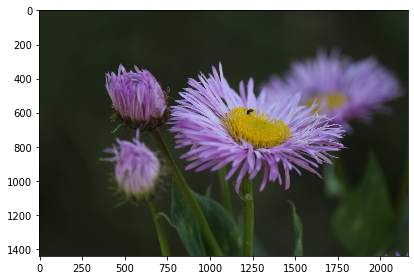

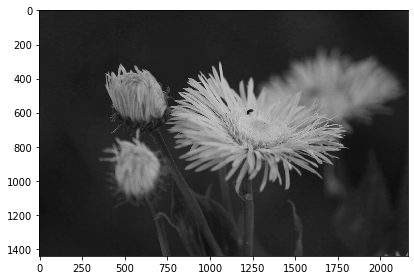

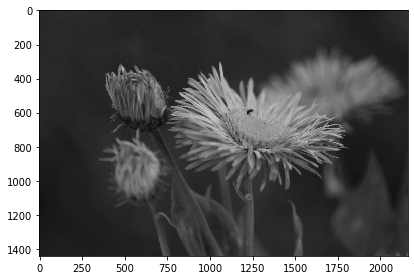

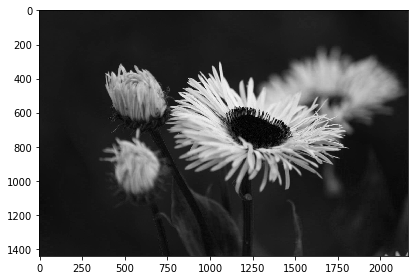

In [3]:
# use method from skimage.io to read "color_example.jpg"
example_image =  skimage.io.imread('color_example.jpg')

show_image(example_image)

# access each color channel, and convert to [0,1] scaled values
#normalized by 255 as systems typically use values between 0-1 when using floating point values
R = example_image[:,:,0]/255  # TBD 
G = example_image[:,:,1]/255  # TBD
B = example_image[:,:,2]/255  # TBD

# show all channels
show_image(R)
show_image(G)
show_image(B)

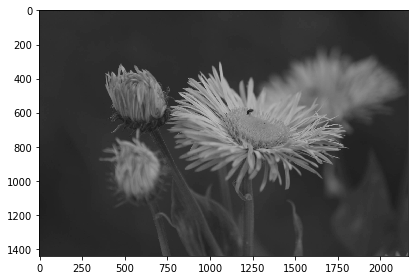

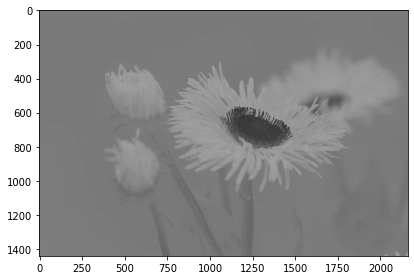

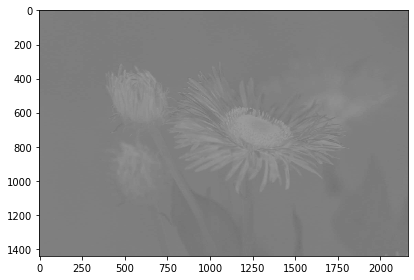

In [4]:
# convert to Y, C_b, C_r

Y =    (65.481 * R + 128.553 * G + 24.966 * B)  + 16
C_b =  (-37.797 * R - 74.203 * G + 112.0 * B) + 128
C_r =  (112.0 * R - 93.786 * G - 18.214 * B) + 128

# important convert type to uint8 
Y =   Y.astype(np.uint8)  
C_b = C_b.astype(np.uint8)
C_r = C_r.astype(np.uint8)

show_image(Y)
show_image(C_b)
show_image(C_r)

In [5]:
# put the steps before into one method
def rgb_to_y_cb_cr(img_rgb): # TBD
    """ method to convert a given RGB image to YC_bC_r according to the steps before,
    """
    # TBD start
    R = img_rgb[:, :, 0]
    G = img_rgb[:, :, 1]
    B = img_rgb[:, :, 2]
    Y =    (65.481 * R + 128.553 * G + 24.966 * B)  + 16
    C_b =  (-37.797 * R - 74.203 * G + 112.0 * B) + 128
    C_r =  (112.0 * R - 93.786 * G - 18.214 * B) + 128
    
    Y = np.array(Y)
    Y = Y.astype(np.uint8)
    C_b = np.array(C_b)
    C_b = C_b.astype(np.uint8)
    C_r = np.array(C_r)
    C_r = C_r.astype(np.uint8)
    # TBD end
    combined = np.zeros(img_rgb.shape, dtype=np.uint8)
    combined[:,:,0] = Y
    combined[:,:,1] = C_b
    combined[:,:,2] = C_r
    return combined

converted = rgb_to_y_cb_cr(example_image)

# save the result
skimage.io.imsave("ycbcr.png", converted)

## Subtask 2: 4:2:0 chroma subsampling
After we are now able to convert RGB images to $YC_bC_r$, we can now implement chroma subsampling.
The general idea here is that human perception is more sensitive to changes in luma than in color.
We will handly 4:2:0 sub sampling in this task, this results in the full resolution for Y and only half of the resolution (thus each second pixel) for each C component in the $YC_bC_r$ color space.



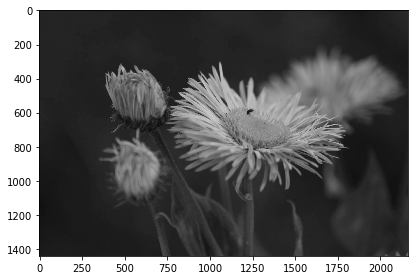

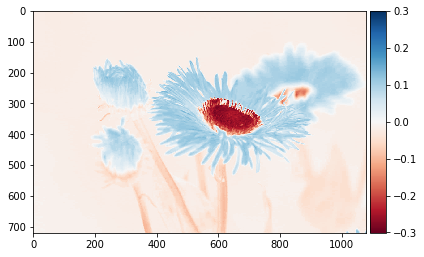

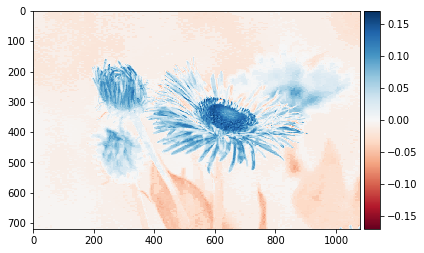

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.3011236885490196, 0.15799272054901956]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.07699792431372553, 0.17027546815686267]. Convert image to uint8 prior to saving to suppress this warning.


In [6]:
# convert example_image to  $YC_bC_r$ using skimage.color.rgb2yuv and perform 4:2:0 chroma subsampling
# note: skimage.color.rgb2yuv is not the same as rgb_to_y_cb_cr, we assume here rgb2yuv \approx ycbcr for demonstration

# use method from skimage.io to read "color_example.jpg"
example_image = skimage.io.imread("color_example.jpg")  # TBD

# convert example image to yuv space, we use this as ycbcr 
ycbcr = skimage.color.rgb2yuv(example_image)   

# select separate components
Y = ycbcr[:,:,0] #As Y is the first position, Cb in second position and Cr in 3rd position so only taking the 0th index for Y component

# sub sample Cb, Cr components, according to 4:2:0 method:
C_b_s = ycbcr[0::2,0::2,1]  # As Cb is in the second position so only taking the 1st index for Cb component and then downsampling it
C_r_s = ycbcr[0::2,0::2,2]  # As Cr is in the third position so only taking the 2nd index for Cr component and then downsampling it


# show each component

show_image(Y)
show_image(C_b_s)
show_image(C_r_s)

# save each component
skimage.io.imsave("Y.png", Y)
skimage.io.imsave("C_b_2.png", C_b_s)
skimage.io.imsave("C_r_0.png", C_r_s)

assert((np.array(C_b_s.shape[0:2]) * 2 == example_image.shape[0:2]).all())
assert((np.array(C_r_s.shape[0:2]) * 2 == example_image.shape[0:2]).all())

In [7]:
# put everything together in one method
def chroma_subsampling_4_2_0(img_rgb):
    """ returns each component with applied 4:2:0 sampling"""
    # TBD start
    Y = ycbcr[:,:,0]
    #Here defining Cb and Cr components separately for further use in the next step (A different approach than the previous task)
    C_b = ycbcr[:,:,1]
    C_r = ycbcr[:,:,2]
    
    #Sub sampling 4:2:0 components using the Cb and Cr components defined above rather than taking ycbcr as a whole and then subsampling it
    C_b_s = C_b[0::2,0::2]  # TBD
    C_r_s = C_r[0::2,0::2] # TBD

    # TBD end
    return np.array([Y, C_b_s, C_r_s])

res_sub_sampling = chroma_subsampling_4_2_0(example_image)


<ipython-input-7-0a7b4f085a56>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([Y, C_b_s, C_r_s])


## Subtask 3: Chrome Keying
Assuming you have a well illuminated scene, with a static colored background (usually blue or green background colors are used). 
The idea is to use a setup consisting of a camera (where parameters like FOV/focal length, camera position are captured), a blue/green box, lights, and some animated/replacement for the background.
Using such a recorded scene will end up, in e.g., the following example image, background and combined version.
(it should be mentioned that the image here is just an example and was processed before to make this task feasable)


<img src="chroma_foreground.jpg" alt="chroma_foreground" style="width: 25%;float: left;"/>
<img src="chroma_background.jpg" alt="chroma_background" style="width: 25%;float: left;"/> 
<img src="chroma_combined.jpg" alt="chroma_combined" style="width: 25%;float: left;"/>

<div style=" clear: both;"></div>

We will handle this task automaticall using python, here we assume a static scene, moreover in a real setup there are more things to be considered (camera position, changing background, ...)



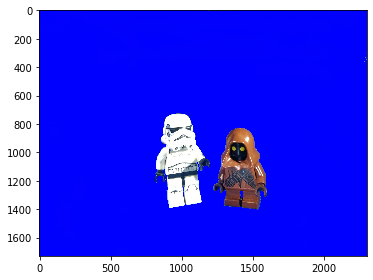

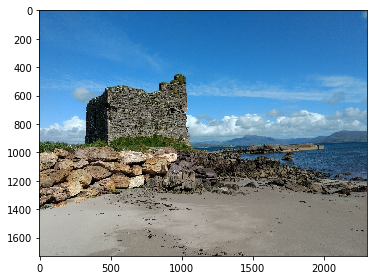

In [8]:
# Hint: read the foreground and background images
# with scikit-image skimage.io function 
# (check for the suitable way)

# read the foreground image
foreground = skimage.io.imread("chroma_foreground.jpg") 
# show foreground image
show_image(foreground)

# read background in a similar manner and show it
background = skimage.io.imread("chroma_background.jpg")
# show background image
show_image(background) 

# check if both images have same shape
assert(foreground.shape == background.shape)

C:\Users\hassa\AppData\Roaming\Python\Python39\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


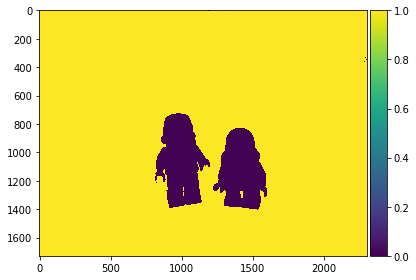

In [9]:
# defined lower blue threshold
lower_threshold = np.array([0, 0, 100])    # [R, G, B] values

# defined upper blue threshold
upper_threshold =  np.array([100, 50, 255]) # TBD

 
def threshold_mask(image, lower_threshold, upper_threshold):
    # for each color channel create a mask based on the defined thresholds
    r_mask = ((image[:,:, 0] >= lower_threshold[0]) & (image[:,:, 0] <= upper_threshold[0]))
    g_mask = ((image[:,:, 1] >= lower_threshold[1]) & (image[:,:, 1] <= upper_threshold[1]))  # TBD
    b_mask = ((image[:,:, 2] >= lower_threshold[2]) & (image[:,:, 2] <= upper_threshold[2]))  # TBD
    # combine the channel masks
    mask_value = r_mask & g_mask & b_mask
    return mask_value.copy().astype('uint8')

# create a mask based on a lower and upper threshold
foreground_mask = threshold_mask(foreground, lower_threshold, upper_threshold)

# show the final foreground mask
show_image(foreground_mask)

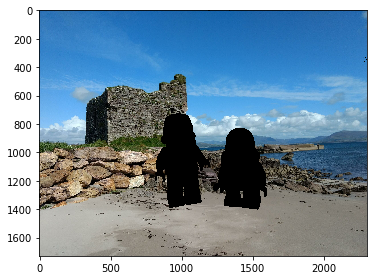

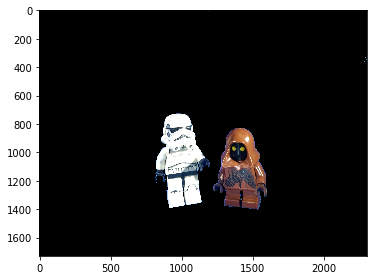

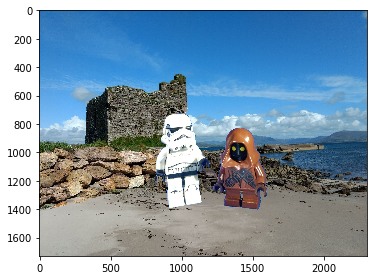

In [10]:
# combine foreground with mask and add background
bg = background.copy()  # copy background image

# for background set the not masked values zero 
bg[foreground_mask != True] = [0, 0, 0]

# copy foreground
fg =  foreground.copy() # TBD 
# for the forground set the masked values to zero
fg[foreground_mask == True] = [0, 0, 0] # TBO

# show both masked images
show_image(bg)
show_image(fg)

# combine fg and bg image
combined_image =  bg +fg # TBD
show_image(combined_image)

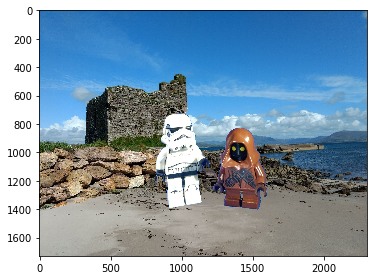

In [11]:
# put everything in one method

def threshold_chroma(foreground, background, lower_threshold, upper_threshold):  # TBD
    """ one method without showing any image, to perform the above implemented steps in one go, 
        * use threshold_mask that was defined before
    """
    # TBD start
    lower_threshold = np.array([0, 0, 100])    # [R, G, B] values

    # defined upper blue threshold
    upper_threshold =  np.array([100, 50, 255]) # TBD
    
     # for each color channel create a mask based on the defined thresholds
    r_mask = ((foreground[:,:, 0] >= lower_threshold[0]) & (foreground[:,:, 0] <= upper_threshold[0]))
    g_mask = ((foreground[:,:, 1] >= lower_threshold[1]) & (foreground[:,:, 1] <= upper_threshold[1]))  # TBD
    b_mask = ((foreground[:,:, 2] >= lower_threshold[2]) & (foreground[:,:, 2] <= upper_threshold[2]))  # TBD
    
    # combine the channel masks
    mask_value = r_mask & g_mask & b_mask
    bg = background.copy()
    #setting the background values which arent masked to 0
    bg[foreground_mask != True] = [0, 0, 0]
    fg = foreground.copy()
    #setting un masked values to zero for foreground
    fg[foreground_mask == True] = [0, 0, 0]
    #combining both images
    combined_image = fg + bg
    
    
    # TBD end
    return combined_image

chroma_res_img = threshold_chroma(foreground, background, lower_threshold, upper_threshold)
show_image(chroma_res_img)

# save resulting combined image
skimage.io.imsave("chroma_result.jpg", chroma_res_img)

## Subtask 4: Salt and pepper noise
This type noise is also known as impulse noise, here some white or black pixels orrcur randomly in an image, removing them will help to improve the image quality and also for later post-processing the noise is usually not required.
They ususally originate from dead pixels inside the camera, thus they can also occur in all three channels (colored salt and pepper noise).


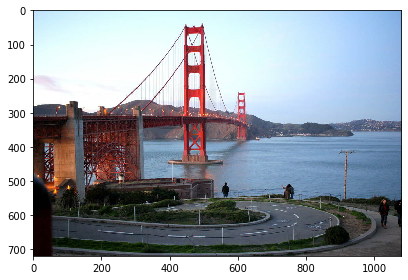

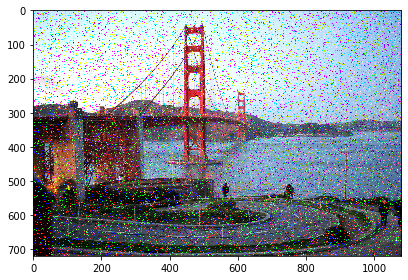

In [12]:
# read the noise_example.jpg

example = skimage.io.imread("noise_example.jpg") # TBD
show_image(example)
# because this image does not have noise, we will include now some noise

def add_salt_pepper_noise(img, SNR):
    img_with_noise = img.copy()
    mask = np.random.choice((0, 1, 2), size=img.shape, p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
    img_with_noise[mask == 1] = 255 # salt noise
    img_with_noise[mask == 2] = 0 # pepper

    return img_with_noise

noise_example = add_salt_pepper_noise(example, 0.9)

show_image(noise_example)

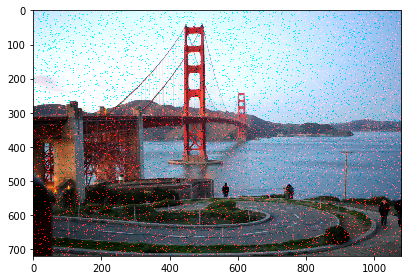

In [13]:
# the next step is to remove the introduced salt and pepper noise,
# a convolution with a median filter for each color component is one possible approach
# here an own implementation is required

def remove_salt_pepper_noise(img_rgb, kernel=(3,3)):
    """ remove colored salt and pepper noise using a convolutional kernel and 
        median filtering per channel
    """
    cleaned_img = img_rgb.copy()
###    # TBD start
    #Kernel
    kernel_size = kernel[0] 
    #Dividing into channels
    red = cleaned_img[:, :, 0] 
    green = cleaned_img[:, :, 1] 
    blue = cleaned_img[:, :, 2] 
    #getting rows and cols for img_rgb
    row = len(img_rgb)
    col = len(img_rgb[0])
    temp_r = []
    temp_g = []
    temp_b = []
    
    #Padding Size
    
    padding = 1 
    
    pad_img_r = np.zeros((red.shape[0]+2*padding, red.shape[1]+2*padding), dtype=np.uint8) #Add Padding
    pad_img_r[padding:pad_img_r.shape[0]-padding, padding:pad_img_r.shape[1]-padding] = red #Add Padding
    for x in range(row):
        for y in range(col):
            temp_r = pad_img_r[x:x+kernel_size, y:y+kernel_size]
            pad_img_r[x+1, y+1] = np.median(temp_r)
    r = pad_img_r[padding:pad_img_r.shape[0] - padding, padding:pad_img_r.shape[1] - padding] #Remove Padding
    
    pad_img_g = np.zeros((green.shape[0]+2*padding, green.shape[1]+2*padding), dtype=np.uint8) 
    pad_img_g[padding:pad_img_g.shape[0]-padding, padding:pad_img_g.shape[1]-padding] = green
    for x in range(row):
        for y in range(col):
            temp_g = pad_img_g[x:x+kernel_size, y:y+kernel_size]
            pad_img_g[x+1, y+1] = np.median(temp_g)
    green = pad_img_g[padding:pad_img_g.shape[0] - padding, padding:pad_img_g.shape[1] - padding] 
    
    pad_img_b = np.zeros((blue.shape[0]+2*padding, blue.shape[1]+2*padding), dtype=np.uint8) 
    pad_img_b[padding:pad_img_b.shape[0]-padding, padding:pad_img_b.shape[1]-padding] = blue
    for x in range(row):
        for y in range(col):
            temp_b = pad_img_b[x:x+kernel_size, y:y+kernel_size]
            pad_img_b[x+1, y+1] = np.median(temp_b)
    blue = pad_img_b[padding:pad_img_b.shape[0] - padding, padding:pad_img_b.shape[1] - padding]
    
    #Combine r,g,b channels
    cleaned_img[:, :, 2] = blue
    cleaned_img[:, :, 1] = green
    cleaned_img[:, :, 0] = red

    
    # saving cleaned image
    skimage.io.imsave("cleaned_image.jpg", cleaned_img)
###    # TBD end
    return cleaned_img

show_image(remove_salt_pepper_noise(noise_example))

In [15]:
print('Finished')

Finished
